In [6]:
import sys, os

import pandas as pd
import numpy as np

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support


import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sn

In [7]:
try:
    data = pd.read_csv('../dataset/clean_bo3.csv', encoding='utf-8-sig', converters={'pre_routes':eval}, index_col=0)
except:
    sys.path.append(os.path.realpath('../'))
    data = pd.read_csv('../dataset/clean_bo3.csv', encoding='utf-8-sig', converters={'pre_routes':eval}, index_col=0)


data.reset_index(level=0, inplace=True)

data.head(10)

,index,vehicle_id,p_start,p_temp,p_end,pre_routes,freq,label
0,0,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.738, 10.8012)","(xa_lộ_hà_nội, xa_lộ_hà_nội, thảo_điền)",121,False
1,16,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.73100000000001, 10.7996)","(xa_lộ_hà_nội, xa_lộ_hà_nội, cầu_sài_gòn_1)",305,False
2,21,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.721, 10.7981)","(xa_lộ_hà_nội, xa_lộ_hà_nội, điện_biên_phủ)",522,False
3,40,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.695, 10.7912)","(xa_lộ_hà_nội, xa_lộ_hà_nội, võ_thị_sáu)",250,False
4,50,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.68799999999999, 10.7858)","(xa_lộ_hà_nội, xa_lộ_hà_nội, nam_kỳ_khởi_nghĩa)",127,False
5,59,100000025,"(106.74, 10.8014)","(106.73899999999999, 10.8012)","(106.681, 10.7926)","(xa_lộ_hà_nội, xa_lộ_hà_nội, nguyễn_văn_trỗi)",299,False
6,102,100000025,"(106.74, 10.8014)","(106.738, 10.8012)","(106.736, 10.8026)","(xa_lộ_hà_nội, thảo_điền, nguyễn_duy_hiệu)",496,False
7,106,100000025,"(106.74, 10.8014)","(106.738, 10.8012)","(106.734, 10.8034)","(xa_lộ_hà_nội, thảo_điền, số_39)",185,False
8,107,100000025,"(106.74, 10.8014)","(106.738, 10.8012)","(106.73200000000001, 10.8028)","(xa_lộ_hà_nội, thảo_điền, quốc_hương)",253,False
9,112,100000025,"(106.74, 10.8014)","(106.738, 10.8012)","(106.73200000000001, 10.8)","(xa_lộ_hà_nội, thảo_điền, empty)",276,False


In [8]:
data['pre_routes'] = data['pre_routes'].apply(lambda x: list(x))
data['label'] = data['label'].apply(lambda label: -1 if label == False else 1)

print("N_normal: ",len(data[data['label']==-1]))
print("N_abnormal: ",len(data[data['label']==1]))
data['label'].describe()

N_normal:  9401
N_abnormal:  5460


count    14861.000000
mean        -0.265191
std          0.964228
min         -1.000000
25%         -1.000000
50%         -1.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64

In [9]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling

X = np.array(data['pre_routes'].tolist())
y = np.array(data['label'].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
vectorizer.fit(X_train)

X_train.shape, X_test.shape, len(vectorizer.get_feature_names())

d:\pythonapp\v2\.envgps-v2\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


((11145, 3), (3716, 3), 439)

# Active Learning

In [10]:
initial_idx = np.random.choice(range(len(X_train)), size=int(X_train.shape[0]*0.6), replace=False)

X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)



precision_test = []
recall_test = []
f1_test = []
acc_test = []

X_initial_mat = vectorizer.transform(X_initial)
X_pool_mat = vectorizer.transform(X_pool)
X_test_mat = vectorizer.transform(X_test)


n_initial = 100
n_queries = 50
clf = SVC(C=5.0, kernel='rbf', tol=1e-5, max_iter=-1, random_state=42, probability=True)


learner = ActiveLearner(
    estimator=clf,
    query_strategy=entropy_sampling,
    X_training=X_initial_mat, y_training=y_initial
)

print(X_initial.shape, X_pool.shape, X_test.shape)

(6687, 3) (4458, 3) (3716, 3)


In [11]:
for i in range(n_queries):
#     print(X_pool_mat.shape)
    try:
        query_idx, query_instance = learner.query(X_pool_mat, n_instances=int(X_pool_mat.shape[0]/n_queries)+1)
    except:
        break

    y_new = y_pool[query_idx]
    learner.teach(X_pool_mat[query_idx], y_new)
    
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    X_pool_mat = vectorizer.transform(X_pool)
    
    y_pred = learner.predict(X_test_mat)

    precision,recall,fscore,support = precision_recall_fscore_support(y_test,y_pred,average='macro')
    precision_test.append(precision)
    recall_test.append(recall)
    f1_test.append(fscore)
    acc_test.append(accuracy_score(y_test,y_pred))
    
    print('F1-score after query {n}: {acc:0.4f}'.format(n=i + 1, acc=f1_test[i]))


    
mean_precision_test = np.mean(precision_test)
mean_recall_test = np.mean(recall_test)
mean_f1_test = np.mean(f1_test)
mean_acc_test = np.mean(acc_test)

test_perfm = [mean_precision_test, mean_recall_test, mean_f1_test, mean_acc_test]

performance = pd.DataFrame([test_perfm], columns = ['precision', 'recall', 'f1-score', 'accuracy'], index=['test'])
performance

F1-score after query 1: 0.9477
F1-score after query 2: 0.9521
F1-score after query 3: 0.9530
F1-score after query 4: 0.9550
F1-score after query 5: 0.9577
F1-score after query 6: 0.9583
F1-score after query 7: 0.9595
F1-score after query 8: 0.9589
F1-score after query 9: 0.9601
F1-score after query 10: 0.9601
F1-score after query 11: 0.9613
F1-score after query 12: 0.9610
F1-score after query 13: 0.9615
F1-score after query 14: 0.9615
F1-score after query 15: 0.9612
F1-score after query 16: 0.9615
F1-score after query 17: 0.9615
F1-score after query 18: 0.9618
F1-score after query 19: 0.9618
F1-score after query 20: 0.9618
F1-score after query 21: 0.9618
F1-score after query 22: 0.9621
F1-score after query 23: 0.9615
F1-score after query 24: 0.9618
F1-score after query 25: 0.9618
F1-score after query 26: 0.9618
F1-score after query 27: 0.9618
F1-score after query 28: 0.9618
F1-score after query 29: 0.9618
F1-score after query 30: 0.9621
F1-score after query 31: 0.9618
F1-score after qu

,precision,recall,f1-score,accuracy
test,0.965713,0.956361,0.960742,0.964311


In [12]:
test_perfm = [precision_test[-1], recall_test[-1], f1_test[-1], acc_test[-1]]
test_perfm_al = pd.DataFrame([test_perfm], columns = ['precision', 'recall', 'f1-score', 'accuracy'], index=['test_al'])
test_perfm_al

,precision,recall,f1-score,accuracy
test_al,0.967388,0.957442,0.962086,0.965554


# Machine Learning

In [13]:
X_train_mat = vectorizer.transform(X_train)
X_test_mat = vectorizer.transform(X_test)

clf = SVC(C=5.0, kernel='rbf', tol=1e-5, max_iter=-1, random_state=42, probability=True)
clf.fit(X_train_mat, y_train)

y_pred_ml = clf.predict(X_test_mat)
ml_precision, ml_recall, ml_fscore, ml_support = precision_recall_fscore_support(y_test,y_pred_ml,average='macro')

ml_acc = accuracy_score(y_test,y_pred_ml)
print(fscore)
test_perfm_ml = pd.DataFrame([[ml_precision,ml_recall,ml_fscore, ml_acc]], columns = ['precision', 'recall', 'f1-score', 'accuracy'], index=['test_ml'])
test_perfm_ml

0.9620855014794409


,precision,recall,f1-score,accuracy
test_ml,0.967411,0.957987,0.962402,0.965823


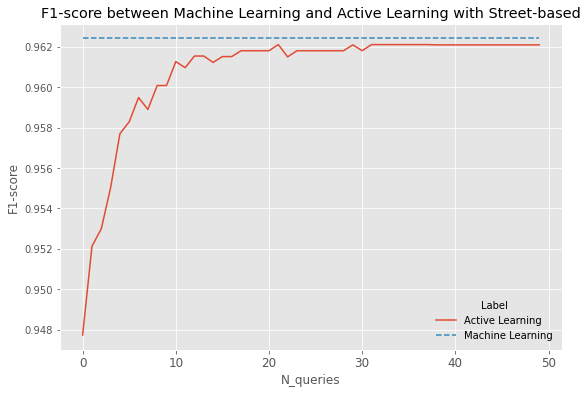

In [14]:
plt.rcParams['figure.figsize'] = (9.0, 6.0)
plt.rcParams['xtick.labelsize'] = 12
plt.plot(range(len(f1_test)),f1_test, label='Active Learning')
plt.plot(range(len(f1_test)),[ml_fscore]*n_queries, '--',label='Machine Learning')
plt.xlabel('N_queries')
plt.ylabel('F1-score')
plt.legend(loc="lower right", title="Label", frameon=False)
plt.title("F1-score between Machine Learning and Active Learning with Street-based")
plt.show()